# <center>Welcome to Supervised Learning</center>
## <center>Part 6: Interpretability</center>
## <center>Instructor: Andras Zsom</center>
### <center>https://github.com/azsom/Supervised-Learning<center>

## The topic of the course series: supervised Machine Learning (ML)
- how to build an ML pipeline from beginning to deployment
- we assume you already performed data cleaning
- this is the sixth course out of 6 courses
    - Part 1: Introduction to machine learning and the bias-variance tradeoff
    - Part 2: How to prepare your data for supervised machine learning
    - Part 3: Evaluation metrics in supervised machine learning
    - Part 4: Non-linear supervised machine learning algorithms
    - Part 5: Missing data in supervised ML
    - **Part 6: Interpretability**
- you can complete the courses in sequence or complete individual courses based on your interest

### Structured data
| X|feature_1|feature_2|...|feature_j|...|feature_m|<font color='red'>Y</font>|
|-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|__data_point_1__|x_11|x_12|...|x_1j|...|x_1m|__<font color='red'>y_1</font>__|
|__data_point_2__|x_21|x_22|...|x_2j|...|x_2m|__<font color='red'>y_2</font>__|
|__...__|...|...|...|...|...|...|__<font color='red'>...</font>__|
|__data_point_i__|x_i1|x_i2|...|x_ij|...|x_im|__<font color='red'>y_i</font>__|
|__...__|...|...|...|...|...|...|__<font color='red'>...</font>__|
|__data_point_n__|x_n1|x_n2|...|x_nj|...|x_nm|__<font color='red'>y_n</font>__|


### Learning objectives of this course

By the end of the course, you will be able to
- Summarize why it is important to explain models
- Describe why additional tools are necessary to explain non-linear models
- Review the difference between global and local feature importance metrics
- Use the coefficients of linear models to measure feature importance
- Apply permutation feature importance to calculate global feature importances
- Describe some model-specific approaches to measure global feature importance
- Describe the intuition behind SHAP values
- Create force, dependence, and summary plots to aid local interpretability 


# Module 1: Global feature importance metrics in linear models
### Learning objectives of this module:
- Summarize why it is important to explain models
- Describe why additional tools are necessary to explain non-linear models
- Review the difference between global and local feature importance metrics
- Use the coefficients of linear models to measure feature importance

## Motivation
 - debugging ML models is tough
    - a model that runs without errors/warning is not necessarily correct
 - how do you know that you model is correct?
    - check test set predictions
       - in regression: check points with a large difference between true and predicted values
       - in classification: confusion matrix, check out FPs and FNs
    - inspect your model
       - especially useful for non-linear models
       - metrics to measure how much a model depends on a feature is one way to inspect your model

### Motivation
<center><img src="figures/int_vs_acc.jpg" width="700"></center>

- local feature importance improves the interpretability of complex models 
- check out [this page](http://yann.lecun.com/exdb/mnist/) for a good example

### Motivation
- can we trust the model?
   - global feeature importance: does the model make predictions based on reasonable features?
   - local feature importance: can we trust the model's prediction for one specific data point?
- global feature importance is often not enough especially when you work with human data
   - medical: the doctor needs to be able to explain the reasoning behind the model prediction to the patient
   - finance: customer wants to know why they were declined a loan/mortgage/credit card/etc

## Coefficients of linear models
- the coefficients of linear and logistic regression can be used as a measure of feature importance **ONLY IF** all features have a zero mean and the same standard deviation (usually 1)
   - all features meaning that the one-hot encoded and ordinal features as well!
- then the absolute value of the coefficients can be used to rank them

### Let's work with the adult dataset
- https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = LabelEncoder().fit_transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [2]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR1(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

/Users/azsom/opt/anaconda3/envs/data1030/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


test score: 0.8581298940580377


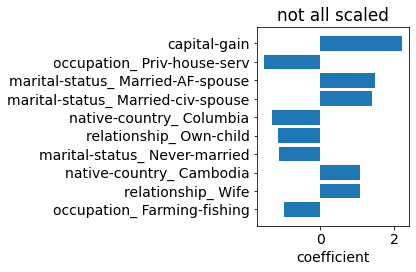

In [3]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR1(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('not all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_notscaled.png',dpi=300)
plt.show()

In [4]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR2(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler,LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

test score: 0.857976354982343


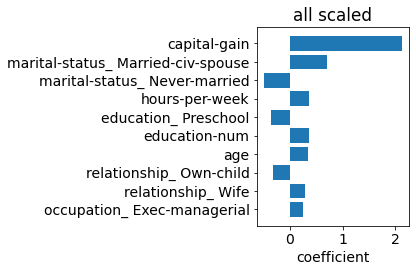

In [5]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR2(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
plt.show()

<table><tr>
<td> <img src="figures/LR_coefs_notscaled.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="figures/LR_coefs_scaled.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

# Module 2: Global feature importance metrics in non-linear models
### Learning objectives of this module:
- Apply permutation feature importance to calculate global feature importances
- Describe some model-specific approaches to measure global feature importance

## Permutation feature importance
 - model agnostic, you can use it with any supervised ML model
 - steps:
    - train a model and calculate a test score :)
    - randomly shuffle a single feature in the test set
    - recalculate the test score with the shuffled data
    - model score worsens because the shuffling breaks the relationship between feature and target
    - the larger the difference, the more important the feature is

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = LabelEncoder().fit_transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [7]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
                  'svc__gamma': [0.01, 0.1, 1, 10, 100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, X_test, y_test

### Be careful, SVM is used on a relatively large dataset

In [8]:
grid, X_test, y_test = ML_pipeline_kfold(X,y,42,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
import pickle
file = open('results/grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 51.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 55.6min finished


0.8545377764127764
0.8624289881774911
{'svc__C': 1, 'svc__gamma': 0.1}


In [9]:
import pickle
file = open('results/grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8624289881774911
test baseline =  0.7587901120835252
shuffling age
   shuffled test score: 0.851 +/- 0.002
shuffling workclass
   shuffled test score: 0.861 +/- 0.001
shuffling fnlwgt
   shuffled test score: 0.862 +/- 0.001
shuffling education
   shuffled test score: 0.86 +/- 0.001
shuffling education-num
   shuffled test score: 0.839 +/- 0.002
shuffling marital-status
   shuffled test score: 0.842 +/- 0.002
shuffling occupation
   shuffled test score: 0.844 +/- 0.002
shuffling relationship
   shuffled test score: 0.851 +/- 0.003
shuffling race
   shuffled test score: 0.862 +/- 0.0
shuffling sex
   shuffled test score: 0.862 +/- 0.0
shuffling capital-gain
   shuffled test score: 0.823 +/- 0.001
shuffling capital-loss
   shuffled test score: 0.855 +/- 0.001
shuffling hours-per-week
   shuffled test score: 0.855 +/- 0.002
shuffling native-country
   shuffled test score: 0.862 +/- 0.001


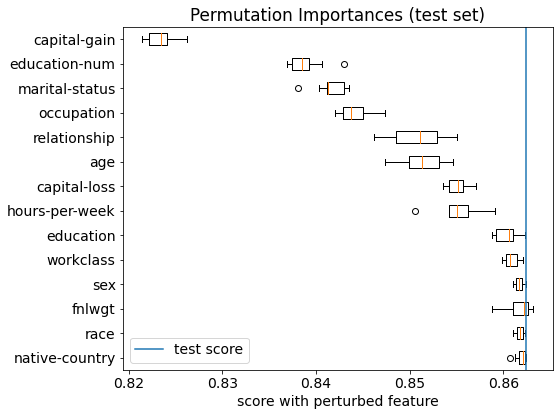

In [10]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## This is also implemented in sklearn

In [11]:
from sklearn.inspection import permutation_importance
import matplotlib.pylab as plt

result = permutation_importance(grid, X_test, y_test, n_repeats=10,random_state=0,scoring='neg_root_mean_squared_error')

scores = result.importances
ftr_names = X_test.columns

In [12]:
from sklearn.metrics import mean_squared_error
y_test_pred = grid.predict(X_test)
test_score = np.sqrt(mean_squared_error(y_test,y_test_pred))

No handles with labels found to put in legend.


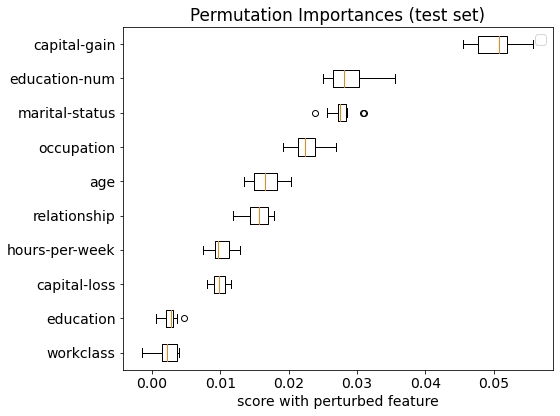

In [13]:
nr_ftrs = 10

sorted_indcs = np.argsort(np.mean(scores,axis=1))
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs[-nr_ftrs:]].T,labels=ftr_names[sorted_indcs[-nr_ftrs:]],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## Cons of permutation feature importance
- strongly correlated features
   - if one of the features is shuffled, the model can still use the other correlated feature
   - both features appear to be less important but they might actually be important
   - solution:
      - check the correlation matrix plot
      - remove all but one of the strongly correlated features
- no feature interactions
   - one feature might appear unimportant but combined with another feature could be important
   - solution:
      - permute two features to measure how important feature pairs are
      - this can be computationally expensive

## Global feature importance in non-linear models
- SVM:
   - SVC.coef_ and SVR.coef_ can be used as a metric of feature importance if **all** features are standardized
   - for linear SVMs only!
- random forest:
   - RandomForestRegressor.feature_importances_ and RandomForestClassification.feature_importances_
   - gini importance or mean decrease impurity, see [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) and [here](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)
- XGBoost:
   - five different metrics are implemented, see [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score) and [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

# Module 3: Local feature importance metrics
### Learning objectives of this module:
- Describe the intuition behind SHAP values
- Create force, dependence, and summary plots to aid local interpretability 

## SHAP values
- one way to calculate local feature importances
- it is based on Shapely values from game theory
- read more [here](https://arxiv.org/abs/1802.03888), [here](https://github.com/slundberg/shap), and [here](https://christophm.github.io/interpretable-ml-book/shap.html)

### Cooperative game theory
- A set of *m* players in a coalition generate a surplus.
- Some players contribute more to the coalition than others (different bargaining powers).
- How important is each player to the coalition?
- How should the surplus be divided fairly amongst the players?

### Cooperative game theory <font color='red'>applied to feature attribution</font>
- A set of *m* <font color='red'>features</font> in a <font color='red'>model</font> generate a <font color='red'>prediction</font>.
- Some <font color='red'>features</font> contribute more to the <font color='red'>model</font> than others (different <font color='red'>predictive</font> powers).
- How important is each <font color='red'>feature</font> to the <font color='red'>model</font>?
- How should the <font color='red'>prediction</font> be divided amongst the <font color='red'>features</font>?

### How is it calculated?
### $\Phi_i = \sum_{S\subseteq M\setminus i}  \frac{|S|!(M - |S| - 1)!} {M!} [f_x(S\cup i) - f_x(S)]$

- $\Phi_i$ - the contribution of feature $i$
- $M$ - the number of features
- $S$ - a set of features excluding $i$, a vector of 0s and 1s (0 if a feature is missing)
- $|S|$ - the number of features in $S$
- $f_x(S)$ - the prediction of the model with features $S$

### How is it calculated?
### $\Phi_i = \sum_{S\subseteq M\setminus i} \color{blue}{\frac{|S|!(M - |S| - 1)!} {M!}}\color{red}{[f_x(S\cup i) - f_x(S)]}$
- <font color='red'>the difference feature $i$ makes in the prediction: </font>
    - <font color='red'>$f_x(S\cup i)$ - the prediction with feature $i$</font>
    - <font color='red'>$f_x(S)$ - the prediction without feature $i$</font>
- loop through all possible ways a set of S features can be selected from the M features excluding i
- <font color='blue'>weight the contribution based on how many ways we can select $|S|$ features</font>

In [14]:
import numpy as np
import pandas as pd
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = LabelEncoder().fit_transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [15]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,RandomForestClassifier(n_estimators =  100,random_state=random_state))
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': [10,30,100,300],
                  'randomforestclassifier__min_samples_split': [16, 32, 64, 128]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

In [16]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold(X,y,42,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  56 out of  64 | elapsed:   34.9s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   39.8s finished


0.862906941031941
0.8667280822969445
{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 64}


In [17]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
# transform the test set
X_test_transformed = grid.best_estimator_[0].transform(X_test)
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000],check_additivity=False)
print(np.shape(shap_values))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


(6513, 108)
(2, 1000, 108)


### Explain a point

In [18]:
index = 1 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_transformed[index,:],feature_names = feature_names)

0.7589753531941029


### Feature value vs. shap value

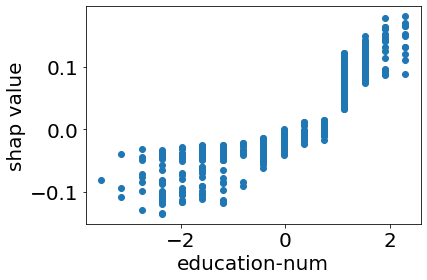

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
ftr = 'education-num'
indx = np.argwhere(feature_names=='education-num')
plt.scatter(X_test_transformed[:1000,indx],shap_values[1][:,indx])
plt.ylabel('shap value')
plt.xlabel(ftr)
plt.show()


### Dependence plot

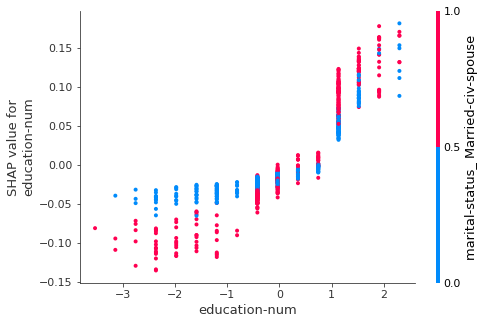

In [20]:
shap.dependence_plot(ftr, shap_values[1], X_test_transformed[:1000], feature_names=feature_names)

### It can also be used for global feature importance

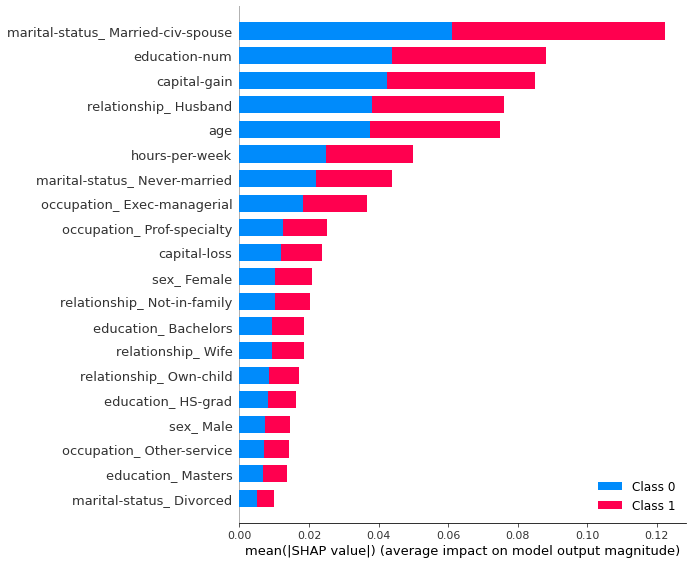

In [21]:
shap.summary_plot(shap_values, X_test_transformed[:1000],feature_names = feature_names)

## SHAP cons
- it can be numerically expensive
   - an efficient shap method was developed for trees, see [here](https://arxiv.org/abs/1905.04610)
- how to estimate $f_x(S)$?
   - this is not trivial because models cannot change the number of features they use
   - usually the values of the dropped features are replaced with the mean or 0
   - this is approximate but no one came up with a better way 